To pair satellite images with PM and Met, this script requires:
- CSV with location names and coordinates 
- Folder with all locations' PM in seperate .xls files. .xls files should be named after location
- CSV with meteorology

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals


# Common imports
import numpy as np
import pandas as pd
import os
# to make this notebook's output stable across runs
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import rasterio
from rasterio.merge import merge
from rasterio.plot import show

import json
from shapely.geometry import shape
from shapely.ops import transform as stransform
from rasterio.mask import mask
from affine import Affine
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import pyproj
import pickle as pkl
import geojson
import cv2

from rasterio.warp import transform as rtransform
from rasterio.transform import rowcol

import PIL
from PIL import Image, ImageEnhance
import sys
# from skimage import io

os.getcwd()

'/Users/sarah/Satellite_Image_Processing'

In [3]:
# #coordinates
my_coordinates = pd.read_excel('../Documents/MultiCityData/IndiaData/ALL_sensors.xlsx')
my_coordinates = my_coordinates.iloc[64:74]
my_coordinates

,SITE,latitude,longitude
64,Bandra,19.053536,72.846430
65,Borivali_East,19.224333,72.865811
66,Chhatrapati,19.100780,72.874620
67,Colaba,18.910000,72.820000
68,Kurla,19.086300,72.888800
69,Powai,19.137500,72.915056
70,Sion,19.047000,72.874600
71,Vasai_West,19.383200,72.820400
72,Vile_Parle_West,19.108610,72.836220
73,Worli,18.993616,72.812811


In [5]:
PM25_dict = {}
for file in sorted(listdir('../Documents/MultiCityData/IndiaData/Mumbai_PM_Spreadsheets')):  #[1:] because MacOS has a weird first output
    if '.xls' in file and file != '.DS_Store':
#         print(file)

        site_name = file.split('.xls')[0]
        print(site_name)
        site_coordinate = (my_coordinates[my_coordinates.SITE == site_name].values[0,1],\
                            my_coordinates[my_coordinates.SITE == site_name].values[0,2])
        print(site_coordinate)
        try:
            df = pd.read_excel(join('../Documents/MultiCityData/IndiaData/Mumbai_PM_Spreadsheets', file))
            df['DATE'] = pd.to_datetime(df['DATE'],dayfirst=True)
            df = df.set_index(pd.DatetimeIndex(df['DATE']))
            df = df[df['PM']!= 'None']
            df_PM25 = df['PM'].to_frame().dropna()
            
            
            if len(df_PM25)>0:
                PM25_dict[site_name] = {'PM':df_PM25, 'coordinate':site_coordinate}
       
        except Exception as e:
            print('error:',e.args)

Bandra
(19.053536, 72.84643)
Borivali_East
(19.2243333, 72.8658113)
Chhatrapati
(19.10078, 72.87462)
Colaba
(18.91, 72.82)
Kurla
(19.0863, 72.8888)
Powai
(19.1375, 72.915056)
Sion
(19.047, 72.8746)
Vasai_West
(19.3832, 72.8204)
Vile_Parle_West
(19.10861, 72.83622)
Worli
(18.9936162, 72.8128113)


In [6]:
date_index = '2019-06-11'
PM25_dict['Worli']['PM'].loc[date_index, 'PM']

17.79

In [7]:
PM25_dict

{'Bandra': {'PM':                PM
  DATE             
  2019-06-04  12.14
  2019-06-05  12.37
  2019-06-06  10.01
  2019-06-07  12.42
  2019-06-08  12.11
  ...           ...
  2021-12-20     38
  2021-12-21     38
  2021-12-22     38
  2021-12-23     38
  2021-12-24     38
  
  [840 rows x 1 columns],
  'coordinate': (19.053536, 72.84643)},
 'Borivali_East': {'PM':                PM
  DATE             
  2019-06-13  11.78
  2019-06-14  13.05
  2019-06-15  11.34
  2019-06-16     10
  2019-06-17  10.66
  ...           ...
  2021-12-26  83.01
  2021-12-27   81.1
  2021-12-28   93.5
  2021-12-29  62.72
  2021-12-30  94.28
  
  [860 rows x 1 columns],
  'coordinate': (19.2243333, 72.8658113)},
 'Chhatrapati': {'PM':                PM
  DATE             
  2019-06-06  14.96
  2019-06-07  13.36
  2019-06-08  15.54
  2019-06-09  15.31
  2019-06-10  18.01
  ...           ...
  2021-12-27  73.08
  2021-12-28  67.35
  2021-12-29  42.95
  2021-12-30  52.46
  2021-12-31     59
  
  [875 rows x 1 

In [5]:
# meteorology_raw_concat_no_NA_daily_avg_final = pd.read_csv('../Downloads/dhaka_met.csv')
# meteorology_raw_concat_no_NA_daily_avg_final['DATE'] = pd.to_datetime(meteorology_raw_concat_no_NA_daily_avg_final['DATE'])
# meteorology_raw_concat_no_NA_daily_avg_final = meteorology_raw_concat_no_NA_daily_avg_final.set_index(pd.DatetimeIndex(meteorology_raw_concat_no_NA_daily_avg_final['DATE']))

# meteorology_raw_concat_no_NA_daily_avg_final.drop(['DATE'], axis = 1, inplace = True)

# meteorology_raw_concat_no_NA_daily_avg_final

In [6]:
# "def PM_Meteo_Matcher(Processed_PM_dfs_concat, coords_AQM):
#     #load PM2.5
#     Processed_PM_dfs_concat = Processed_PM_dfs_concat.apply(lambda x: pd.to_numeric(x))
    
#     cur_lat, cur_long = coords_AQM 
# #     print(Processed_PM_dfs_concat, cur_lat, cur_long)
#     #sort meteorology stations based on their distances to the AQM station
#     #sort default in ascending order
#     #meteo_stations_closest_in_order = [station_id for station_id ,_, _ in \
#     #        sorted(zip(meteo_station_IDs, meteo_station_lats, meteo_station_longs), \
#     #               key=lambda triplet: geopy.distance.vincenty(coords_AQM, (triplet[1], triplet[2])).km)]
    
#     #Matching meteo to PM2.5
#     Processed_PM_dfs_concat_meteo = pd.merge(Processed_PM_dfs_concat, meteorology_raw_concat_no_NA_daily_avg_final,\
#                                              left_index=True,right_index=True,how='inner').resample('1d').mean().dropna()
#     '''
#     for station_id in meteo_stations_closest_in_order[1:]:
#         meteo_missing_index  = Processed_PM_dfs_concat_meteo[Processed_PM_dfs_concat_meteo.iloc[:,1:].isna().any(1)].index
#         if len(meteo_missing_index)>0:
#             #print(meteo_missing_index)
#             Processed_PM_dfs_concat_meteo.loc[meteo_missing_index,kept_features] = \
#             Processed_PM_dfs_concat_meteo.loc[meteo_missing_index,kept_features].fillna(LA_meteo[station_id].loc[meteo_missing_index,kept_features])
#         else:
#             break
#     '''
#     #Processed_PM_dfs_concat_meteo.dropna(inplace = True)
#     return Processed_PM_dfs_concat_meteo"

In [7]:
# PM25_meteo_matched = {key:PM_Meteo_Matcher(PM25_dict[key]['PM25'], PM25_dict[key]['coordinate']) for key in PM25_dict.keys()}

In [7]:
# PM25_meteo_matched

In [9]:
final_image_path = '../Desktop/central_school_crop/20180526_044048_1029_3B_Visual.tif'
station_index = final_image_path.split('/')[2]
time_index = final_image_path.split('/')[-1].split('_')[1]
time_index = time_index[0:2]+':'+time_index[2:4]+':' +time_index[4:]
id_index = final_image_path.split('/')[-1].split('_')[2]
id_index
date_index = final_image_path.split('/')[-1].split('_')[0]

date_index = date_index[0:4] + '-' + date_index[4:6] + '-' + date_index[6:]
# print(date_index[5:7])
print(date_index, time_index, id_index)

2018-05-26 04:40:48 1029


In [53]:
matching_PM25 = PM25_meteo_matched[station_index][PM25_meteo_matched[station_index].index == date_index].iloc[0,0]
matching_PM25

matching_meteo = PM25_meteo_matched[station_index][PM25_meteo_matched[station_index].index == date_index].iloc[0,1:]
matching_meteo

TEMP     67.8
VISIB     2.0
WDSP      5.5
RH       61.0
Name: 2021-12-20 00:00:00, dtype: float64

In [11]:
for f in sorted(listdir('../Desktop/Jaipar/Adarsh_Nagar')):
    print(f)

20180105_082244_0f4c_3B_Visual.tif
20180110_045708_0f22_3B_Visual.tif
20180112_045701_1031_3B_Visual.tif
20180115_045637_1021_3B_Visual.tif
20180122_045653_101b_3B_Visual.tif
20180127_045723_1033_3B_Visual.tif
20180128_045651_0f18_3B_Visual.tif
20180130_045724_1044_3B_Visual.tif
20180130_045725_1044_3B_Visual.tif
20180131_050014_0e16_3B_Visual.tif
20180203_045813_1011_3B_Visual.tif
20180207_045740_1015_3B_Visual.tif
20180208_045928_0f52_3B_Visual.tif
20180210_053755_0f21_3B_Visual.tif
20180212_053831_1050_3B_Visual.tif
20180212_053832_1050_3B_Visual.tif
20180215_045927_0e20_3B_Visual.tif
20180215_053713_1052_3B_Visual.tif
20180223_045752_1010_3B_Visual.tif
20180225_053633_0f3c_3B_Visual.tif
20180227_053546_0f4b_3B_Visual.tif
20180303_045912_1022_3B_Visual.tif
20180317_053408_0f36_3B_Visual.tif
20180321_045846_1010_3B_Visual.tif
20180321_045847_1010_3B_Visual.tif
20180325_050003_1008_3B_Visual.tif
20180327_050024_101e_3B_Visual.tif
20180401_045954_1004_3B_Visual.tif
20180405_050034_1044

In [13]:
def Imagery_matcher(final_image_path):
    try:
#         print('site loading')
        im = np.moveaxis(rasterio.open(final_image_path).read(), 0, 2)
        img_arr = np.array(im)
#         print('read in working')
    except Exception as e:
        print(e)
        return None
    
    black_space = np.mean(img_arr[:,:,:]/255)


    if black_space > .91 or black_space <= 0.4:
#         print(black_space)
#         plt.imshow(im)
#         plt.show()
        return None
    else:
        
        station_index = final_image_path.split('/')[3]
        time_index = final_image_path.split('/')[-1].split('_')[1]
        time_index = time_index[0:2]+':'+time_index[2:4]+':' +time_index[4:]
        date_index = final_image_path.split('/')[-1].split('_')[0]
        date_index = date_index[0:4] + '-' + date_index[4:6] + '-' + date_index[6:]
        id_index = final_image_path.split('/')[-1].split('_')[2]
#         print('indexes working: ',station_index, time_index, date_index, id_index)
#         plt.imshow(im)
#         plt.show()

    try:
        matching_PM25 = PM25_dict[station_index]['PM'].loc[date_index, 'PM']
        
#         matching_PM25 = PM25_meteo_matched[station_index][PM25_meteo_matched[station_index].index == date_index].iloc[0,0]
        print('matched pm working:', matching_PM25)
        
#         matching_meteo = PM25_meteo_matched[station_index][PM25_meteo_matched[station_index].index == date_index].iloc[0,1:]
#         print('matched met working')
        
    except Exception as e:
        print(e)
        return None

    return({'Image':im, 'PM':matching_PM25, 'Date':date_index, 'Time_stamp':time_index,
            'Station_index': station_index, 'Sat_ID':id_index})

#     return({'Image':im, 'PM':matching_PM25, 'Meteo':matching_meteo, 'Date':date_index, 'Time_stamp':time_index,
#             'Station_index': station_index, 'Sat_ID':id_index})





In [14]:
def Image_loader(image_folder_path):
    print(image_folder_path)
    Matching_data_for_a_single_station = [Imagery_matcher(join(image_folder_path, f)) for f in sorted(listdir(image_folder_path)) \
                            if isfile(join(image_folder_path, f)) and '.DS_Store' not in str(f)\
                                         and Imagery_matcher(join(image_folder_path, f)) is not None]
    return Matching_data_for_a_single_station

In [15]:
AQM_data_for_model = [Image_loader('../Desktop/Mumbai/' + site) for site in my_coordinates.SITE]

../Desktop/Mumbai/Bandra
'2019-06-02'
matched pm working: 12.14
matched pm working: 12.14
matched pm working: 12.37
matched pm working: 12.37
matched pm working: 12.37
matched pm working: 12.37
matched pm working: 12.42
matched pm working: 12.42
matched pm working: 12.42
matched pm working: 12.42
matched pm working: 17.48
matched pm working: 17.48
matched pm working: 16.44
matched pm working: 16.44
matched pm working: 11.71
matched pm working: 11.71
matched pm working: 12
matched pm working: 12
matched pm working: 12
matched pm working: 12
matched pm working: 12
matched pm working: 12
matched pm working: 13.89
matched pm working: 13.89
matched pm working: 13.89
matched pm working: 13.89
matched pm working: 13.89
matched pm working: 13.89
matched pm working: 14.37
matched pm working: 14.37
matched pm working: 15.65
matched pm working: 15.65
matched pm working: 14.24
matched pm working: 14.24
matched pm working: 11.97
matched pm working: 11.97
matched pm working: 32.3
matched pm working:

/Users/sarah/opt/anaconda3/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


matched pm working: 23.09
matched pm working: 23.09
matched pm working: 26.59
matched pm working: 26.59
matched pm working: 25.19
matched pm working: 25.19
matched pm working: 32.5
matched pm working: 32.5
matched pm working: 32.5
matched pm working: 32.5
matched pm working: 35.17
matched pm working: 35.17
matched pm working: 19.79
matched pm working: 19.79
matched pm working: 25.56
matched pm working: 25.56
matched pm working: 29.6
matched pm working: 29.6
matched pm working: 40.72
matched pm working: 40.72
matched pm working: 40.72
matched pm working: 40.72
matched pm working: 41.63
matched pm working: 41.63
matched pm working: 49.69
matched pm working: 49.69
matched pm working: 17.31
matched pm working: 17.31
matched pm working: 30.13
matched pm working: 30.13
matched pm working: 9.8
matched pm working: 9.8
matched pm working: 18.45
matched pm working: 18.45
matched pm working: 18.45
matched pm working: 18.45
matched pm working: 25.94
matched pm working: 25.94
matched pm working: 27

matched pm working: 66.63
matched pm working: 82.35
matched pm working: 82.35
matched pm working: 82.35
matched pm working: 82.35
matched pm working: 61.08
matched pm working: 61.08
matched pm working: 61.08
matched pm working: 61.08
matched pm working: 60.93
matched pm working: 60.93
matched pm working: 47.66
matched pm working: 47.66
matched pm working: 60.98
matched pm working: 60.98
matched pm working: 47.09
matched pm working: 47.09
matched pm working: 47.09
matched pm working: 47.09
matched pm working: 47.09
matched pm working: 47.09
matched pm working: 67.55
matched pm working: 67.55
matched pm working: 67.55
matched pm working: 67.55
'2020-06-05'
matched pm working: 8.45
matched pm working: 8.45
matched pm working: 8.45
matched pm working: 8.45
matched pm working: 8.45
matched pm working: 8.45
matched pm working: 8.63
matched pm working: 8.63
matched pm working: 8.59
matched pm working: 8.59
matched pm working: 8.59
matched pm working: 8.59
matched pm working: 8.59
matched pm w

'2021-03-15'
'2021-03-16'
'2021-03-16'
'2021-03-16'
'2021-03-17'
'2021-03-18'
'2021-03-19'
'2021-03-21'
'2021-03-23'
'2021-03-23'
matched pm working: 48
matched pm working: 48
matched pm working: 65.44
matched pm working: 65.44
matched pm working: 65.44
matched pm working: 65.44
matched pm working: 48.12
matched pm working: 48.12
matched pm working: 48
matched pm working: 48
matched pm working: 48
matched pm working: 48
matched pm working: 48
matched pm working: 48
matched pm working: 48
matched pm working: 48
matched pm working: 48
matched pm working: 48
matched pm working: 61.11
matched pm working: 61.11
matched pm working: 61.11
matched pm working: 61.11
matched pm working: 44.09
matched pm working: 44.09
matched pm working: 44.09
matched pm working: 44.09
matched pm working: 58.1
matched pm working: 58.1
matched pm working: 58.1
matched pm working: 58.1
matched pm working: 47.06
matched pm working: 47.06
matched pm working: 40.07
matched pm working: 40.07
matched pm working: 29.06


'2021-10-26'
'2021-10-28'
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 38
matched pm working: 44.88
matched pm working: 44.88
matched pm working: 44.88
matched pm working: 44.88
matched pm working: 45.73
matched pm working: 45.73
matched pm working: 45.73
matched pm

matched pm working: 61.36
matched pm working: 61.36
matched pm working: 69.88
matched pm working: 69.88
matched pm working: 12.54
matched pm working: 12.54
matched pm working: 16.29
matched pm working: 16.29
matched pm working: 36.51
matched pm working: 36.51
matched pm working: 36.51
matched pm working: 36.51
matched pm working: 47.28
matched pm working: 47.28
matched pm working: 57.36
matched pm working: 57.36
matched pm working: 57.36
matched pm working: 57.36
matched pm working: 49.82
matched pm working: 49.82
matched pm working: 55.17
matched pm working: 55.17
matched pm working: 55.17
matched pm working: 55.17
matched pm working: 56.61
matched pm working: 56.61
matched pm working: 56.61
matched pm working: 56.61
matched pm working: 56.61
matched pm working: 56.61
matched pm working: 43.42
matched pm working: 43.42
matched pm working: 41.44
matched pm working: 41.44
matched pm working: 48.05
matched pm working: 48.05
matched pm working: 45.19
matched pm working: 45.19
matched pm w

matched pm working: 86.1
matched pm working: 86.1
matched pm working: 86.1
matched pm working: 73.45
matched pm working: 73.45
matched pm working: 73.45
matched pm working: 73.45
matched pm working: 66.54
matched pm working: 66.54
matched pm working: 66.54
matched pm working: 66.54
matched pm working: 54.14
matched pm working: 54.14
matched pm working: 54.14
matched pm working: 54.14
matched pm working: 57.9
matched pm working: 57.9
matched pm working: 57.9
matched pm working: 57.9
matched pm working: 57.87
matched pm working: 57.87
matched pm working: 37.5
matched pm working: 37.5
matched pm working: 59.32
matched pm working: 59.32
matched pm working: 56.11
matched pm working: 56.11
matched pm working: 56.11
matched pm working: 56.11
matched pm working: 56.11
matched pm working: 56.11
matched pm working: 93.47
matched pm working: 93.47
matched pm working: 93.47
matched pm working: 93.47
matched pm working: 99.85
matched pm working: 99.85
matched pm working: 99.85
matched pm working: 9

matched pm working: 17.91
matched pm working: 17.91
matched pm working: 17.91
matched pm working: 17.91
matched pm working: 17.91
matched pm working: 12.93
matched pm working: 12.93
matched pm working: 12.93
matched pm working: 12.93
matched pm working: 10.48
matched pm working: 10.48
matched pm working: 10.48
matched pm working: 10.48
matched pm working: 10.48
matched pm working: 10.48
matched pm working: 10.48
matched pm working: 10.48
matched pm working: 11.11
matched pm working: 11.11
matched pm working: 11.11
matched pm working: 11.11
matched pm working: 11.11
matched pm working: 11.11
matched pm working: 13.52
matched pm working: 13.52
matched pm working: 18.58
matched pm working: 18.58
matched pm working: 18.58
matched pm working: 18.58
matched pm working: 12.78
matched pm working: 12.78
matched pm working: 12.43
matched pm working: 12.43
matched pm working: 13.18
matched pm working: 13.18
matched pm working: 13.18
matched pm working: 13.18
matched pm working: 10.35
matched pm w

matched pm working: 87.99
matched pm working: 87.99
matched pm working: 84.35
matched pm working: 84.35
matched pm working: 72.33
matched pm working: 72.33
matched pm working: 62.96
matched pm working: 62.96
matched pm working: 98.81
matched pm working: 98.81
matched pm working: 98.81
matched pm working: 98.81
matched pm working: 130.45
matched pm working: 130.45
matched pm working: 130.45
matched pm working: 130.45
matched pm working: 130.45
matched pm working: 130.45
matched pm working: 102.51
matched pm working: 102.51
matched pm working: 102.51
matched pm working: 102.51
matched pm working: 97.43
matched pm working: 97.43
matched pm working: 97.43
matched pm working: 97.43
matched pm working: 97.43
matched pm working: 97.43
matched pm working: 97.43
matched pm working: 97.43
matched pm working: 106.76
matched pm working: 106.76
matched pm working: 107.63
matched pm working: 107.63
matched pm working: 98.68
matched pm working: 98.68
matched pm working: 98.68
matched pm working: 98.6

matched pm working: 58.81
matched pm working: 57.48
matched pm working: 57.48
matched pm working: 57.48
matched pm working: 57.48
matched pm working: 45.11
matched pm working: 45.11
matched pm working: 53.09
matched pm working: 53.09
matched pm working: 53.09
matched pm working: 53.09
matched pm working: 63.13
matched pm working: 63.13
matched pm working: 57.14
matched pm working: 57.14
matched pm working: 57.14
matched pm working: 57.14
matched pm working: 65.18
matched pm working: 65.18
matched pm working: 91.71
matched pm working: 91.71
matched pm working: 91.71
matched pm working: 91.71
matched pm working: 61.9
matched pm working: 61.9
matched pm working: 74.66
matched pm working: 74.66
matched pm working: 74.66
matched pm working: 74.66
matched pm working: 74.66
matched pm working: 74.66
matched pm working: 82.43
matched pm working: 82.43
matched pm working: 66.04
matched pm working: 66.04
matched pm working: 66.04
matched pm working: 66.04
matched pm working: 59.14
matched pm wor

matched pm working: 15.7
matched pm working: 15.7
matched pm working: 15.7
matched pm working: 15.7
matched pm working: 13.86
matched pm working: 13.86
matched pm working: 13.86
matched pm working: 13.86
matched pm working: 13.86
matched pm working: 13.86
matched pm working: 13.86
matched pm working: 13.86
matched pm working: 13.2
matched pm working: 13.2
matched pm working: 13.2
matched pm working: 13.2
matched pm working: 11.84
matched pm working: 11.84
matched pm working: 12.22
matched pm working: 12.22
matched pm working: 21.3
matched pm working: 21.3
matched pm working: 38.59
matched pm working: 38.59
matched pm working: 38.59
matched pm working: 38.59
matched pm working: 38.59
matched pm working: 38.59
matched pm working: 27.42
matched pm working: 27.42
matched pm working: 27.42
matched pm working: 27.42
matched pm working: 27.68
matched pm working: 27.68
matched pm working: 27.68
matched pm working: 27.68
matched pm working: 27.68
matched pm working: 27.68
matched pm working: 24

matched pm working: 73.08
matched pm working: 73.08
matched pm working: 73.08
matched pm working: 67.35
matched pm working: 67.35
matched pm working: 67.35
matched pm working: 67.35
matched pm working: 67.35
matched pm working: 67.35
matched pm working: 42.95
matched pm working: 42.95
matched pm working: 42.95
matched pm working: 42.95
matched pm working: 52.46
matched pm working: 52.46
../Desktop/Mumbai/Colaba
'2019-06-02'
'2019-06-05'
'2019-06-05'
'2019-06-07'
'2019-06-11'
'2019-06-11'
'2019-06-16'
'2019-06-20'
'2019-06-20'
'2019-06-21'
'2019-06-22'
matched pm working: 9.14
matched pm working: 9.14
matched pm working: 9.14
matched pm working: 9.14
matched pm working: 10.36
matched pm working: 10.36
matched pm working: 10.36
matched pm working: 10.36
matched pm working: 8.73
matched pm working: 8.73
matched pm working: 11.9
matched pm working: 11.9
matched pm working: 14.45
matched pm working: 14.45
matched pm working: 14.61
matched pm working: 14.61
matched pm working: 19.04
matched 

matched pm working: 26.74
matched pm working: 26.74
matched pm working: 26.74
matched pm working: 48.92
matched pm working: 48.92
matched pm working: 64.24
matched pm working: 64.24
matched pm working: 17.86
matched pm working: 17.86
matched pm working: 20.11
matched pm working: 20.11
matched pm working: 20.3
matched pm working: 20.3
matched pm working: 23.65
matched pm working: 23.65
matched pm working: 23.65
matched pm working: 23.65
matched pm working: 23.65
matched pm working: 23.65
matched pm working: 33.01
matched pm working: 33.01
matched pm working: 20.18
matched pm working: 20.18
matched pm working: 20.18
matched pm working: 20.18
matched pm working: 30.56
matched pm working: 30.56
matched pm working: 21.97
matched pm working: 21.97
matched pm working: 23.37
matched pm working: 23.37
matched pm working: 23.09
matched pm working: 23.09
matched pm working: 28.05
matched pm working: 28.05
'2020-04-10'
'2020-04-12'
'2020-04-13'
'2020-04-13'
matched pm working: 16.92
matched pm wor

matched pm working: 46.75
matched pm working: 46.75
matched pm working: 46.75
matched pm working: 60.44
matched pm working: 60.44
matched pm working: 60.44
matched pm working: 60.44
matched pm working: 60.44
matched pm working: 60.44
matched pm working: 60.44
matched pm working: 60.44
matched pm working: 37.18
matched pm working: 37.18
matched pm working: 51.5
matched pm working: 51.5
matched pm working: 53.76
matched pm working: 53.76
matched pm working: 53.76
matched pm working: 53.76
matched pm working: 43.72
matched pm working: 43.72
matched pm working: 43.72
matched pm working: 43.72
matched pm working: 56.46
matched pm working: 56.46
matched pm working: 56.46
matched pm working: 56.46
matched pm working: 56.46
matched pm working: 56.46
matched pm working: 42.88
matched pm working: 42.88
matched pm working: 31.97
matched pm working: 31.97
matched pm working: 43.69
matched pm working: 43.69
matched pm working: 48.87
matched pm working: 48.87
matched pm working: 48.87
matched pm wor

matched pm working: 35.26
matched pm working: 36.79
matched pm working: 36.79
matched pm working: 36.79
matched pm working: 36.79
matched pm working: 32.53
matched pm working: 32.53
matched pm working: 32.53
matched pm working: 32.53
matched pm working: 34.31
matched pm working: 34.31
matched pm working: 34.31
matched pm working: 34.31
matched pm working: 16.12
matched pm working: 16.12
matched pm working: 16.12
matched pm working: 16.12
matched pm working: 9.98
matched pm working: 9.98
matched pm working: 9.98
matched pm working: 9.98
matched pm working: 11.73
matched pm working: 11.73
matched pm working: 11.73
matched pm working: 11.73
matched pm working: 11.73
matched pm working: 11.73
matched pm working: 11.73
matched pm working: 11.73
matched pm working: 11.73
matched pm working: 11.73
matched pm working: 11.73
matched pm working: 11.73
matched pm working: 33.93
matched pm working: 33.93
matched pm working: 33.93
matched pm working: 33.93
matched pm working: 45.76
matched pm worki

matched pm working: 19.79
matched pm working: 19.79
matched pm working: 19.53
matched pm working: 19.53
matched pm working: 28.18
matched pm working: 28.18
matched pm working: 61.38
matched pm working: 61.38
matched pm working: 71.66
matched pm working: 71.66
matched pm working: 74.46
matched pm working: 74.46
matched pm working: 100.76
matched pm working: 100.76
matched pm working: 75.26
matched pm working: 75.26
matched pm working: 78.07
matched pm working: 78.07
matched pm working: 85.95
matched pm working: 85.95
matched pm working: 85.95
matched pm working: 85.95
matched pm working: 44.37
matched pm working: 44.37
matched pm working: 82.38
matched pm working: 82.38
matched pm working: 106.95
matched pm working: 106.95
matched pm working: 106.66
matched pm working: 106.66
matched pm working: 75.03
matched pm working: 75.03
matched pm working: 75.03
matched pm working: 75.03
matched pm working: 77.2
matched pm working: 77.2
matched pm working: 108.15
matched pm working: 108.15
matche

matched pm working: 56.37
matched pm working: 100.6
matched pm working: 100.6
matched pm working: 100.6
matched pm working: 100.6
matched pm working: 76
matched pm working: 76
matched pm working: 76
matched pm working: 76
matched pm working: 43.07
matched pm working: 43.07
matched pm working: 43.07
matched pm working: 43.07
matched pm working: 43.4
matched pm working: 43.4
matched pm working: 52.82
matched pm working: 52.82
matched pm working: 70.16
matched pm working: 70.16
matched pm working: 71.18
matched pm working: 71.18
matched pm working: 79.32
matched pm working: 79.32
matched pm working: 87.82
matched pm working: 87.82
matched pm working: 87.82
matched pm working: 87.82
matched pm working: 58.77
matched pm working: 58.77
matched pm working: 52.4
matched pm working: 52.4
matched pm working: 53.87
matched pm working: 53.87
matched pm working: 53.87
matched pm working: 53.87
matched pm working: 53.87
matched pm working: 53.87
matched pm working: 53.87
matched pm working: 53.87
ma

matched pm working: 31.33
matched pm working: 31.33
matched pm working: 31.33
matched pm working: 31.33
matched pm working: 31.33
matched pm working: 31.33
matched pm working: 31.33
matched pm working: 31.33
matched pm working: 31.33
matched pm working: 31.33
matched pm working: 36.23
matched pm working: 36.23
matched pm working: 54.46
matched pm working: 54.46
matched pm working: 68.71
matched pm working: 68.71
matched pm working: 68.71
matched pm working: 68.71
matched pm working: 90.09
matched pm working: 90.09
matched pm working: 90.09
matched pm working: 90.09
matched pm working: 64.47
matched pm working: 64.47
matched pm working: 64.47
matched pm working: 64.47
matched pm working: 64.47
matched pm working: 64.47
matched pm working: 64.47
matched pm working: 64.47
matched pm working: 78.47
matched pm working: 78.47
matched pm working: 78.47
matched pm working: 78.47
matched pm working: 47.23
matched pm working: 47.23
matched pm working: 47.23
matched pm working: 47.23
matched pm w

matched pm working: 41.51
matched pm working: 51.52
matched pm working: 51.52
matched pm working: 41.37
matched pm working: 41.37
matched pm working: 48.99
matched pm working: 48.99
matched pm working: 57.17
matched pm working: 57.17
matched pm working: 59.53
matched pm working: 59.53
matched pm working: 43.38
matched pm working: 43.38
matched pm working: 19.52
matched pm working: 19.52
matched pm working: 17.41
matched pm working: 17.41
matched pm working: 17.41
matched pm working: 17.41
matched pm working: 23.99
matched pm working: 23.99
matched pm working: 23.99
matched pm working: 23.99
matched pm working: 32.25
matched pm working: 32.25
matched pm working: 32.25
matched pm working: 32.25
matched pm working: 44.48
matched pm working: 44.48
matched pm working: 18.83
matched pm working: 18.83
matched pm working: 47.58
matched pm working: 47.58
matched pm working: 47.58
matched pm working: 47.58
matched pm working: 47.58
matched pm working: 47.58
matched pm working: 54.62
matched pm w

matched pm working: 21.22
matched pm working: 21.22
matched pm working: 26.3
matched pm working: 26.3
matched pm working: 17.71
matched pm working: 17.71
matched pm working: 20.04
matched pm working: 20.04
matched pm working: 20.04
matched pm working: 20.04
matched pm working: 15.02
matched pm working: 15.02
matched pm working: 14.1
matched pm working: 14.1
matched pm working: 14.1
matched pm working: 14.1
matched pm working: 18.09
matched pm working: 18.09
matched pm working: 14.13
matched pm working: 14.13
matched pm working: 10.92
matched pm working: 10.92
matched pm working: 10.92
matched pm working: 10.92
matched pm working: 8.88
matched pm working: 8.88
matched pm working: 10.08
matched pm working: 10.08
matched pm working: 9.34
matched pm working: 9.34
matched pm working: 12.25
matched pm working: 12.25
matched pm working: 12.25
matched pm working: 12.25
matched pm working: 11.47
matched pm working: 11.47
matched pm working: 15.44
matched pm working: 15.44
matched pm working: 12

matched pm working: 81.91
matched pm working: 81.91
matched pm working: 81.91
matched pm working: 81.91
matched pm working: 60.18
matched pm working: 60.18
matched pm working: 40.56
matched pm working: 40.56
matched pm working: 40.56
matched pm working: 40.56
matched pm working: 40.56
matched pm working: 40.56
matched pm working: 42.54
matched pm working: 42.54
matched pm working: 54.67
matched pm working: 54.67
matched pm working: 63.7
matched pm working: 63.7
matched pm working: 55.46
matched pm working: 55.46
matched pm working: 83.88
matched pm working: 83.88
matched pm working: 64.48
matched pm working: 64.48
matched pm working: 45.85
matched pm working: 45.85
matched pm working: 45.85
matched pm working: 45.85
matched pm working: 45.85
matched pm working: 45.85
matched pm working: 33.63
matched pm working: 33.63
matched pm working: 33.63
matched pm working: 33.63
matched pm working: 33.63
matched pm working: 33.63
matched pm working: 33.63
matched pm working: 33.63
matched pm wor

matched pm working: 17.37
matched pm working: 17.37
matched pm working: 17.37
matched pm working: 24.76
matched pm working: 24.76
matched pm working: 24.76
matched pm working: 24.76
matched pm working: 23.77
matched pm working: 23.77
matched pm working: 34.29
matched pm working: 34.29
matched pm working: 34.29
matched pm working: 34.29
matched pm working: 34.29
matched pm working: 34.29
matched pm working: 37.04
matched pm working: 37.04
matched pm working: 30.71
matched pm working: 30.71
matched pm working: 30.71
matched pm working: 30.71
matched pm working: 30.71
matched pm working: 30.71
matched pm working: 30.71
matched pm working: 30.71
matched pm working: 20.24
matched pm working: 20.24
matched pm working: 25.45
matched pm working: 25.45
matched pm working: 25.45
matched pm working: 25.45
matched pm working: 25.45
matched pm working: 25.45
matched pm working: 35.05
matched pm working: 35.05
matched pm working: 35.05
matched pm working: 35.05
matched pm working: 47.23
matched pm w

matched pm working: 23.36
matched pm working: 23.36
matched pm working: 20.85
matched pm working: 20.85
matched pm working: 43.03
matched pm working: 43.03
matched pm working: 88.59
matched pm working: 88.59
matched pm working: 21.93
matched pm working: 21.93
matched pm working: 21.93
matched pm working: 21.93
matched pm working: 38.4
matched pm working: 38.4
matched pm working: 48.26
matched pm working: 48.26
matched pm working: 48.26
matched pm working: 48.26
matched pm working: 67.47
matched pm working: 67.47
matched pm working: 20.76
matched pm working: 20.76
matched pm working: 37.66
matched pm working: 37.66
matched pm working: 37.66
matched pm working: 37.66
matched pm working: 75.06
matched pm working: 75.06
matched pm working: 63.14
matched pm working: 63.14
matched pm working: 63.14
matched pm working: 63.14
matched pm working: 82.68
matched pm working: 82.68
matched pm working: 82.68
matched pm working: 82.68
matched pm working: 78.78
matched pm working: 78.78
matched pm wor

matched pm working: 14.06
matched pm working: 14.06
matched pm working: 14.06
matched pm working: 18.03
matched pm working: 18.03
matched pm working: 18.88
matched pm working: 18.88
matched pm working: 13.6
matched pm working: 13.6
matched pm working: 12.43
matched pm working: 12.43
matched pm working: 16.76
matched pm working: 16.76
matched pm working: 11.72
matched pm working: 11.72
matched pm working: 11.67
matched pm working: 11.67
matched pm working: 11.67
matched pm working: 11.67
matched pm working: 14.63
matched pm working: 14.63
matched pm working: 27.96
matched pm working: 27.96
matched pm working: 15.6
matched pm working: 15.6
matched pm working: 13.83
matched pm working: 13.83
matched pm working: 14.51
matched pm working: 14.51
matched pm working: 15.2
matched pm working: 15.2
matched pm working: 15.2
matched pm working: 15.2
matched pm working: 14.13
matched pm working: 14.13
matched pm working: 14.13
matched pm working: 14.13
matched pm working: 13.15
matched pm working: 

matched pm working: 94.88
matched pm working: 94.88
matched pm working: 94.88
matched pm working: 94.88
matched pm working: 94.88
matched pm working: 60.71
matched pm working: 60.71
matched pm working: 61.49
matched pm working: 61.49
matched pm working: 61.49
matched pm working: 61.49
matched pm working: 104.62
matched pm working: 104.62
matched pm working: 75.38
matched pm working: 75.38
matched pm working: 75.38
matched pm working: 75.38
matched pm working: 75.38
matched pm working: 75.38
matched pm working: 67.4
matched pm working: 67.4
matched pm working: 67.4
matched pm working: 67.4
matched pm working: 72.62
matched pm working: 72.62
matched pm working: 72.62
matched pm working: 72.62
matched pm working: 79.71
matched pm working: 79.71
matched pm working: 79.71
matched pm working: 79.71
matched pm working: 79.71
matched pm working: 79.71
matched pm working: 54.06
matched pm working: 54.06
matched pm working: 39.3
matched pm working: 39.3
matched pm working: 56.69
matched pm worki

matched pm working: 21.13
matched pm working: 21.13
matched pm working: 21.32
matched pm working: 21.32
matched pm working: 23.88
matched pm working: 23.88
matched pm working: 17.81
matched pm working: 17.81
matched pm working: 17.04
matched pm working: 17.04
matched pm working: 17.04
matched pm working: 17.04
matched pm working: 17.04
matched pm working: 17.04
matched pm working: 16.42
matched pm working: 16.42
matched pm working: 25.55
matched pm working: 25.55
matched pm working: 25.55
matched pm working: 25.55
matched pm working: 12.88
matched pm working: 12.88
matched pm working: 11.74
matched pm working: 11.74
matched pm working: 19.35
matched pm working: 19.35
matched pm working: 20.75
matched pm working: 20.75
matched pm working: 17.45
matched pm working: 17.45
matched pm working: 9.84
matched pm working: 9.84
matched pm working: 19.65
matched pm working: 19.65
matched pm working: 19.65
matched pm working: 19.65
matched pm working: 19.65
matched pm working: 19.65
matched pm wor

matched pm working: 8.56
matched pm working: 8.56
matched pm working: 8.86
matched pm working: 8.86
matched pm working: 12.57
matched pm working: 12.57
matched pm working: 12.57
matched pm working: 12.57
matched pm working: 15.34
matched pm working: 15.34
matched pm working: 15.34
matched pm working: 15.34
matched pm working: 17.87
matched pm working: 17.87
matched pm working: 17.87
matched pm working: 17.87
'2019-07-16'
'2019-07-17'
'2019-07-23'
'2019-08-11'
matched pm working: 17.43
matched pm working: 17.43
matched pm working: 48.08
matched pm working: 48.08
matched pm working: 22.62
matched pm working: 22.62
matched pm working: 43.3
matched pm working: 43.3
matched pm working: 59.71
matched pm working: 59.71
matched pm working: 35.06
matched pm working: 35.06
matched pm working: 86.09
matched pm working: 86.09
matched pm working: 72.64
matched pm working: 72.64
matched pm working: 91.99
matched pm working: 91.99
matched pm working: 105.68
matched pm working: 105.68
matched pm worki

matched pm working: 68.42
matched pm working: 68.42
matched pm working: 68.42
matched pm working: 68.42
matched pm working: 68.42
matched pm working: 68.42
matched pm working: 68.42
matched pm working: 68.42
matched pm working: 68.42
matched pm working: 68.42
matched pm working: 66.39
matched pm working: 66.39
matched pm working: 72.8
matched pm working: 72.8
matched pm working: 72.8
matched pm working: 72.8
matched pm working: 73.92
matched pm working: 73.92
matched pm working: 73.92
matched pm working: 73.92
matched pm working: 47.45
matched pm working: 47.45
matched pm working: 45.05
matched pm working: 45.05
matched pm working: 45.05
matched pm working: 45.05
matched pm working: 45.05
matched pm working: 45.05
matched pm working: 53.37
matched pm working: 53.37
matched pm working: 63.19
matched pm working: 63.19
matched pm working: 63.19
matched pm working: 63.19
matched pm working: 52.27
matched pm working: 52.27
matched pm working: 52.27
matched pm working: 52.27
matched pm worki

matched pm working: 27.2
matched pm working: 27.2
matched pm working: 27.2
matched pm working: 27.2
matched pm working: 27.2
matched pm working: 27.2
matched pm working: 27.2
matched pm working: 30.14
matched pm working: 30.14
matched pm working: 30.14
matched pm working: 30.14
matched pm working: 29.96
matched pm working: 29.96
matched pm working: 30.03
matched pm working: 30.03
matched pm working: 26.86
matched pm working: 26.86
matched pm working: 26.86
matched pm working: 26.86
matched pm working: 30.25
matched pm working: 30.25
matched pm working: 36.15
matched pm working: 36.15
matched pm working: 29.58
matched pm working: 29.58
matched pm working: 29.58
matched pm working: 29.58
matched pm working: 29.19
matched pm working: 29.19
matched pm working: 32.88
matched pm working: 32.88
matched pm working: 32.88
matched pm working: 32.88
matched pm working: 32.88
matched pm working: 32.88
matched pm working: 29.2
matched pm working: 29.2
matched pm working: 30.01
matched pm working: 3

matched pm working: 77.41
matched pm working: 77.41
matched pm working: 80.43
matched pm working: 80.43
matched pm working: 80.43
matched pm working: 80.43
matched pm working: 76.8
matched pm working: 76.8
matched pm working: 86.92
matched pm working: 86.92
matched pm working: 86.92
matched pm working: 86.92
matched pm working: 77.35
matched pm working: 77.35
matched pm working: 94.31
matched pm working: 94.31
matched pm working: 94.31
matched pm working: 94.31
matched pm working: 94.31
matched pm working: 94.31
matched pm working: 94.31
matched pm working: 94.31
matched pm working: 82.38
matched pm working: 82.38
matched pm working: 74.38
matched pm working: 74.38
matched pm working: 74.38
matched pm working: 74.38
matched pm working: 74.38
matched pm working: 74.38
matched pm working: 74.38
matched pm working: 74.38
matched pm working: 64.9
matched pm working: 64.9
matched pm working: 32.52
matched pm working: 32.52
matched pm working: 40.16
matched pm working: 40.16
matched pm worki

matched pm working: 69.61
matched pm working: 122.93
matched pm working: 122.93
matched pm working: 111.85
matched pm working: 111.85
matched pm working: 72.32
matched pm working: 72.32
matched pm working: 45.25
matched pm working: 45.25
matched pm working: 72.32
matched pm working: 72.32
matched pm working: 79.63
matched pm working: 79.63
matched pm working: 79.63
matched pm working: 79.63
matched pm working: 78.47
matched pm working: 78.47
matched pm working: 79.98
matched pm working: 79.98
matched pm working: 58.41
matched pm working: 58.41
matched pm working: 58.41
matched pm working: 58.41
matched pm working: 100.81
matched pm working: 100.81
matched pm working: 107.28
matched pm working: 107.28
matched pm working: 111.73
matched pm working: 111.73
matched pm working: 111.73
matched pm working: 111.73
matched pm working: 81.91
matched pm working: 81.91
matched pm working: 107.24
matched pm working: 107.24
matched pm working: 126.91
matched pm working: 126.91
matched pm working: 15

matched pm working: 19.94
matched pm working: 19.94
matched pm working: 19.38
matched pm working: 19.38
matched pm working: 19.38
matched pm working: 19.38
matched pm working: 22.96
matched pm working: 22.96
matched pm working: 21.65
matched pm working: 21.65
matched pm working: 23.59
matched pm working: 23.59
matched pm working: 21.83
matched pm working: 21.83
matched pm working: 29.34
matched pm working: 29.34
matched pm working: 29.34
matched pm working: 29.34
matched pm working: 29.34
matched pm working: 29.34
matched pm working: 29.34
matched pm working: 29.34
matched pm working: 29.34
matched pm working: 29.34
matched pm working: 29.34
matched pm working: 29.34
matched pm working: 33.98
matched pm working: 33.98
matched pm working: 33.98
matched pm working: 33.98
matched pm working: 33.98
matched pm working: 33.98
matched pm working: 31.45
matched pm working: 31.45
matched pm working: 31.45
matched pm working: 31.45
matched pm working: 29.29
matched pm working: 29.29
matched pm w

matched pm working: 112.24
matched pm working: 112.24
matched pm working: 119.26
matched pm working: 119.26
matched pm working: 119.26
matched pm working: 119.26
matched pm working: 119.26
matched pm working: 119.26
matched pm working: 100.53
matched pm working: 100.53
matched pm working: 100.53
matched pm working: 100.53
matched pm working: 100.53
matched pm working: 100.53
matched pm working: 91.63
matched pm working: 91.63
../Desktop/Mumbai/Worli
'2019-06-02'
'2019-06-04'
'2019-06-05'
'2019-06-05'
'2019-06-05'
'2019-06-07'
'2019-06-07'
'2019-06-07'
matched pm working: 17.79
matched pm working: 17.79
matched pm working: 10.32
matched pm working: 10.32
matched pm working: 16.02
matched pm working: 16.02
matched pm working: 16.02
matched pm working: 16.02
matched pm working: 13.83
matched pm working: 13.83
matched pm working: 19.75
matched pm working: 19.75
matched pm working: 14.04
matched pm working: 14.04
matched pm working: 6.49
matched pm working: 6.49
matched pm working: 6.49
mat

matched pm working: 28.22
matched pm working: 31.71
matched pm working: 31.71
matched pm working: 25.01
matched pm working: 25.01
matched pm working: 26.27
matched pm working: 26.27
matched pm working: 27.39
matched pm working: 27.39
matched pm working: 29.09
matched pm working: 29.09
matched pm working: 21.7
matched pm working: 21.7
matched pm working: 26.04
matched pm working: 26.04
'2020-04-12'
'2020-04-13'
'2020-04-13'
'2020-04-13'
matched pm working: 17.24
matched pm working: 17.24
matched pm working: 20.04
matched pm working: 20.04
matched pm working: 20.04
matched pm working: 20.04
matched pm working: 18.61
matched pm working: 18.61
matched pm working: 16.09
matched pm working: 16.09
matched pm working: 19.41
matched pm working: 19.41
matched pm working: 21.44
matched pm working: 21.44
matched pm working: 14.99
matched pm working: 14.99
matched pm working: 12.88
matched pm working: 12.88
matched pm working: 11.2
matched pm working: 11.2
matched pm working: 13.27
matched pm worki

matched pm working: 64.14
matched pm working: 64.14
matched pm working: 69.31
matched pm working: 69.31
matched pm working: 68.25
matched pm working: 68.25
matched pm working: 68.25
matched pm working: 68.25
matched pm working: 106.52
matched pm working: 106.52
matched pm working: 106.52
matched pm working: 106.52
matched pm working: 100.54
matched pm working: 100.54
matched pm working: 100.54
matched pm working: 100.54
matched pm working: 73.26
matched pm working: 73.26
matched pm working: 73.26
matched pm working: 73.26
matched pm working: 73.26
matched pm working: 73.26
matched pm working: 50.83
matched pm working: 50.83
matched pm working: 38.74
matched pm working: 38.74
matched pm working: 45.83
matched pm working: 45.83
matched pm working: 115.68
matched pm working: 115.68
matched pm working: 51.83
matched pm working: 51.83
matched pm working: 62.41
matched pm working: 62.41
matched pm working: 72.84
matched pm working: 72.84
matched pm working: 106.66
matched pm working: 106.66


matched pm working: 16.8
matched pm working: 16.8
matched pm working: 16.8
matched pm working: 16.8
matched pm working: 16.8
matched pm working: 16.8
matched pm working: 32.22
matched pm working: 32.22
matched pm working: 32.22
matched pm working: 32.22
matched pm working: 32.22
matched pm working: 32.22
matched pm working: 42.09
matched pm working: 42.09
matched pm working: 59.24
matched pm working: 59.24
matched pm working: 59.24
matched pm working: 59.24
matched pm working: 59.24
matched pm working: 59.24
matched pm working: 59.24
matched pm working: 59.24
matched pm working: 93.52
matched pm working: 93.52
matched pm working: 93.52
matched pm working: 93.52
matched pm working: 68.93
matched pm working: 68.93
matched pm working: 52.8
matched pm working: 52.8
matched pm working: 52.8
matched pm working: 52.8
matched pm working: 52.8
matched pm working: 52.8
matched pm working: 60.52
matched pm working: 60.52
matched pm working: 60.52
matched pm working: 60.52
matched pm working: 60.5

In [17]:
for i in range(len(AQM_data_for_model[4])):
    print(AQM_data_for_model[4][i]['PM'])
#     h = len(AQM_data_for_model[i])
#     print(np.sum(h))

17.68
17.68
23.23
15.9
20.35
16.11
12.38
20.96
23.82
23.82
25.03
19.53
28.18
61.38
71.66
74.46
100.76
75.26
78.07
85.95
85.95
44.37
82.38
106.95
106.66
75.03
75.03
77.2
108.15
103.59
96.84
95.77
95.77
87.96
87.96
125.51
115.54
83.01
83.01
59.02
59.02
59.76
60.07
60.07
71.88
71.88
23.15
23.15
23.15
34.09
34.09
61.27
97.67
97.67
76.72
87.61
48.42
58.28
58.28
53.04
53.04
53.04
25.46
25.25
25.25
10.41
14.54
9.58
9.58
10.75
7.75
6.24
24.17
12.02
22.18
22.18
35.96
63.62
15.12
15.12
63.84
63.84
63.84
91.98
77.86
71.55
71.55
82.92
82.92
91
86.03
86.03
82.67
97.62
97.62
94.57
94.57
81.17
86.77
93.03
102.46
75.16
92.16
117.34
117.34
120.96
72.93
42.85
77.7
86.93
86.93
86.93
95.27
99.17
71.72
71.72
71.72
71.72
110.87
110.87
113.57
113.57
100.67
100.67
117.83
151.17
151.17
146.83
176.41
141.76
141.76
99.7
99.7
108.81
108.81
105
105
104.14
104.14
76.27
76.27
87.34
87.34
90.45
53.6
53.6
97.4
93.42
93.42
110.13
110.13
142.87
142.87
142.87
70.76
86.36
86.36
107.8
113.62
107.53
107.53
92.2
93.07
93.07


In [18]:
print(AQM_data_for_model[0][0])

# len(AQM_data_for_model[2])

{'Image': array([[[220, 208, 193, 255],
        [220, 208, 192, 255],
        [225, 212, 197, 255],
        ...,
        [203, 192, 179, 255],
        [204, 193, 179, 255],
        [202, 191, 177, 255]],

       [[220, 208, 193, 255],
        [221, 209, 194, 255],
        [226, 214, 198, 255],
        ...,
        [203, 192, 179, 255],
        [204, 193, 180, 255],
        [206, 195, 182, 255]],

       [[220, 208, 193, 255],
        [221, 209, 194, 255],
        [228, 216, 200, 255],
        ...,
        [205, 194, 180, 255],
        [205, 195, 182, 255],
        [205, 195, 182, 255]],

       ...,

       [[205, 195, 180, 255],
        [204, 194, 178, 255],
        [204, 194, 178, 255],
        ...,
        [198, 188, 172, 255],
        [197, 187, 171, 255],
        [196, 188, 171, 255]],

       [[203, 194, 179, 255],
        [204, 194, 178, 255],
        [203, 194, 178, 255],
        ...,
        [198, 188, 173, 255],
        [197, 188, 172, 255],
        [194, 185, 169, 255]],

  

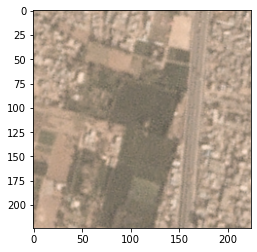

In [31]:
plt.imshow(AQM_data_for_model[2][0]['Image'])

In [19]:
with open("../Desktop/Mumbai.pkl", "wb") as fp:
    pkl.dump(AQM_data_for_model, fp)

In [87]:
df = pd.DataFrame(AQM_data_for_model, columns=['Image', 'PM', 'Meteo','Date','Time_stamp','Station_index','Sat_ID'])

<!-- def image_pairing(image_path):
    try:

#         im = Image.open(image_path).convert('LA')
        im = np.moveaxis(rasterio.open(image_path).read(), 0, 2)
        img_arr = np.array(im)
        sat_id = path.split('/')[3].split('_')[2]
        date = image_path.split('/')[3].split('_')[0]
        date = date[0:4] + '-' + date[4:6] + '-' + date[6:]
        time = image_path.split('/')[3].split('_')[1]
        time = time[0:2]+':'+time[2:4]+':' +time[4:]

#         print(img_arr, sat_id, date,time)
    except:
        print(image_path+' path cannot be found')

    black_space = np.mean(img_arr[:,:,:]/255)
# #     print(black_space)
# #     plt.imshow(im[:,:,1])
# #     plt.show()

# #     if black_space >= 65:
# #         print(black_space)
# #         plt.imshow(im[:,:,1])
# #         plt.show()

    matching_PM25 = PM25_meteo_matched[station_index][PM25_meteo_matched[station_index].index == image_time_index].iloc[0,0]
    matching_meteo = PM25_meteo_matched[station_index][PM25_meteo_matched[station_index].index == image_time_index].iloc[0,1:]
    if date not in kalanki \
    or black_space <= 10 \
    or black_space >= 70:
        print('invalid ', date)
        print(black_space)
#         plt.imshow(im[:,:,0])
#         plt.show()

    
    else:
        print(black_space)
        matching_PM25 = kalanki[date]
        print('valid ', date)

  
        return {'Image': im,'PM': matching_PM25, 'Date': date, 'Time': time, 'Sat_id': sat_id, 'Station': 'Kalanki'} -->

<!-- #meteo and PM
df         =  pd.read_excel("Downloads/Kath_PM/usembassy.xls")
dfbudhani  =  pd.read_excel('Downloads/Kath_PM/budhanilkantha.xls')
dfamerican =  pd.read_excel('Downloads/Kath_PM/americanclub.xls')
dfthamel   =  pd.read_excel('Downloads/Kath_PM/thamel.xls')
dfkote     =  pd.read_excel('Downloads/Kath_PM/koteshwore.xls')
dfkalanki  =  pd.read_excel('Downloads/Kath_PM/kalanki.xls')
dfgyn      =  pd.read_excel('Downloads/Kath_PM/gyaneshwore.xls')


usembassy    = {}
americanclub = {}
budhani      = {}
thamel       = {}
kote         = {}
kalanki      = {}
gyn          = {}

for index, row in df.iterrows():
    usembassy[row["DATE"]] = row["PM25"]
    
for index,row in dfamerican.iterrows():
    americanclub[row['DATE']] = row['PM25']

for index, row in dfbudhani.iterrows():
    budhani[row['DATE']] = row['PM25']

for index, row in dfthamel.iterrows():
    thamel[row['DATE']] = row['PM25']
    
for index, row in dfkote.iterrows():
    kote[row['DATE']] = row['PM25']
    
for index, row in dfkalanki.iterrows():
    kalanki[row['DATE']] = row['PM25']
    
for index, row in dfgyn.iterrows():
    dfgyn['DATE'] = pd.to_datetime(dfgyn['DATE'])
    dfgyn['DATE'].dt.strftime('%Y-%m-%d')
    gyn[row['DATE']] = row['PM25'] -->

In [ ]:
# dfgyn      =  pd.read_excel('Downloads/Kath_PM/gyaneshwore.xls', converters= {'DATE': pd.to_datetime})
# for index, row in dfgyn.iterrows():
# #     dfgyn['DATE'] = pd.to_datetime(dfgyn['DATE'])
# #     dfgyn['DATE'].dt.strftime('%Y-%m-%d')
#     gyn[row['DATE']] = row['PM25']
# gyn

In [9]:
# #CRITICAL. Discarding of all images that do not match the regular shape size
# import os

# directory = 'Documents/planet_imgs/thamel_imgs'

# for filename in sorted(os.listdir(directory)):
#     if filename.endswith(".tif"): 
#         img = cv2.imread(os.path.join(directory, filename))
# #         plt.imshow(img)
# #         plt.show()
#         h,w,_ = img.shape
# #         print(h,w)
#         if (not (h ==479 and w == 479)):

#             print(os.path.join(directory, filename))
#             print(h,w)
#             os.remove(os.path.join(directory,filename))

# #         else:
# #             continue

In [11]:
# pm25_dict['usembassy']

In [12]:
# # embassy_list = []
# # for path in tqdm(testdir, position=0, leave=True):
# mypath = testdir + path
# #     img = Image.open(mypath)
# img = cv2.imread(testdir)    
# img_arr = np.array(img)
# print(np.mean(img_arr[:,:,:])/255)

# plt.imshow(img[:,:,1])
# plt.show()

# print(img.shape)
# name = os.path.basename(mypath).split('_')[0]
# name = name[0:4] + '-' + name[4:6] + '-' + name[6:]
    
# #     if name in avg_PM_emb \
# #     and img_arr.shape == (479, 479, 3) \
# #     and np.mean(img_arr[:,:,:])/255 >= 0.03:
            
# #         embassy_list.append([img_arr, avg_PM_emb[name]])


<!-- directory = 'Documents/planet_imgs/gyaneshwore'

for filename in sorted(os.listdir(directory)):
    print(filename)
#     sat_id = filename.split('_')[2]
#     print(sat_id)
# date = path.split('/')[3].split('_')[0]
# date = date[0:4] + '-' + date[4:6] + '-' + date[6:]
# print(date)

# time = path.split('/')[3].split('_')[1]
# time = time[0:2]+':'+time[2:4]+':' +time[4:]
# print(time) -->

<!-- def image_pairing(image_path):
    
    try:
#         im = Image.open(image_path).convert('LA')
        im = np.moveaxis(rasterio.open(image_path).read(), 0, 2)
        img_arr = np.array(im)
        sat_id = path.split('/')[3].split('_')[2]
        date = image_path.split('/')[3].split('_')[0]
        date = date[0:4] + '-' + date[4:6] + '-' + date[6:]
        time = image_path.split('/')[3].split('_')[1]
        time = time[0:2]+':'+time[2:4]+':' +time[4:]

        print(img_arr, sat_id, date,time)
    except:
        print(image_path+' path cannot be found')

    black_space = np.mean(img_arr[:,:,:]/255)
# #     print(black_space)
    plt.imshow(im[:,:,1])
    plt.show()
#     print(sat_id)

# #     if black_space >= 65:
# #         print(black_space)
# #         plt.imshow(im[:,:,1])
# #         plt.show()
    if date not in gyn \
    or black_space <= 10 \
    or black_space >= 70:
        print('invalid ', date)
        print(black_space)
#         plt.imshow(im[:,:,0])
#         plt.show()

    
    else:
        print(black_space)
        matching_PM25 = gyn[date]
        print('valid ', date)

  
        return {'Image': im,'PM': matching_PM25, 'Date': date, 'Time': time, 'Sat_id': sat_id, 'Station': 'Gyn'} -->

13 <= club <= 70

10 <= USembassy <= 65

10 <= budhani <= 70

<!-- # def Image_loader(image_folder_path):
#     my_current_image_path = image_folder_path
#     Matching_data_for_a_single_station = [image_pairing(join(my_current_image_path,f)) for f in sorted(listdir(my_current_image_path)) \
#                                       if isfile(join(my_current_image_path, f)) and '.DS_Store' not in str(f)]

#     Matching_data_for_a_single_station = list(filter(None, Matching_data_for_a_single_station))
#     return Matching_data_for_a_single_station -->

<!-- # American_club = Image_loader('Documents/planet_imgs/americanclub')
# US_embassy = Image_loader('Documents/planet_imgs/usembassy')
# budhani = Image_loader('Documents/planet_imgs/bud_imgs')
# thamel = Image_loader('Documents/planet_imgs/thamel_imgs')
# kote = Image_loader('Documents/planet_imgs/kote_imgs')
# kalank = Image_loader('Documents/planet_imgs/kalanki_imgs')
gyna = Image_loader('Documents/planet_imgs/gyaneshwore/') -->